In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import time
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.data_utils import load_config, load_tensor, LDL_Stim_Dataset,read_data_inference
from utils.train_utils import train, validate
from utils.inference_utils import get_representation,learn_B_for_one_sample, estimate_y_one_sample
from utils.inference_utils import calculate_mae, learn_B, estimate_y, get_tsne,learn_B_val
from utils.loss import recon_loss, sup_loss,matching_loss, AverageMeter
from config.config import DEVICE

## Load Data

In [3]:
#For conditions m=0, S=25,p=[0.1,0.25,0.5]
data_path = "./data/sync6d-p10-seed-100"+ "/{}-{}.{}" # p=0.1
# data_path = "./data/sync6d-p25-seed-100"+ "/{}-{}.{}"   # p=0.25
# data_path = "./data/sync6d-p50-seed-100"+ "/{}-{}.{}"  #  p=0.5

#For conditions p=0.5, S=25, m = [0.3,0.5,0.7]
# data_path = "./data/sync6d-miss-0.3-seed-100"+ "/{}-{}.{}"  #m = 0.3
# data_path = "./data/sync6d-miss-0.5-seed-100"+ "/{}-{}.{}"  #m = 0.5
# data_path = "./data/sync6d-miss-0.7-seed-100"+ "/{}-{}.{}"  #m = 0.7

train_dataset = LDL_Stim_Dataset(data_path, fold = 'train',device = DEVICE)
val_dataset = LDL_Stim_Dataset(data_path, fold = 'val',device = DEVICE)

tensor([0.0186, 0.1691, 1.0957], device='cuda:3') tensor([ 1.0008,  4.4556, 10.6405], device='cuda:3')
x_full: torch.Size([1200, 25, 3])
t_full: torch.Size([1200, 25, 3])
mask_full: torch.Size([1200, 25, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([1200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])
tensor([-1.9966e-04,  8.4547e-02,  8.9924e-01], device='cuda:3') tensor([ 0.9848,  4.3756, 10.3170], device='cuda:3')
x_full: torch.Size([1200, 25, 3])
t_full: torch.Size([1200, 25, 3])
mask_full: torch.Size([1200, 25, 3])
batch_ind_full: torch.Size([1200])
y_full: torch.Size([1200, 5])
y_control: torch.Size([1000, 5, 1])
treatment_effect: torch.Size([200, 5, 1])
y_mask_full: torch.Size([1200])
m: torch.Size([3])
sd: torch.Size([3])


In [4]:
train_data_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True)
val_data_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)

## Model

In [5]:
### Transformer model
from models.models import Trans_Encoder,Trans_Decoder,linear_cls
encoder = Trans_Encoder().to(DEVICE)
decoder = Trans_Decoder().to(DEVICE)
Q = linear_cls(1600).to(DEVICE)

### LSTM model
# from models.models import LSTM_Encoder,LSTM_Decoder,linear_cls
# encoder = LSTM_Encoder(in_dim = 3,hidden_dim = 20).to(DEVICE)
# decoder = LSTM_Decoder(hidden_dim = 40,out_dim = 3,time_points = 25).to(DEVICE)
# Q = linear_cls(40).to(DEVICE)

### CNN model
# from models.models import CNN_Encoder,CNN_Decoder,linear_cls
# encoder = CNN_Encoder(input_nc = 3).to(DEVICE)
# decoder = CNN_Decoder(lat_chan=128,out_ch = 3).to(DEVICE)
# Q = linear_cls(128).to(DEVICE)

### Linear model
# from models.models import Linear_Encoder,Linear_Decoder,linear_cls
# encoder = Linear_Encoder(input_nc = 3).to(DEVICE)
# decoder = Linear_Decoder(lat_chan=128,out_ch = 3).to(DEVICE)
# Q = linear_cls(25).to(DEVICE)



## Testing
x,t,m,y,y_mask   = next(iter(train_data_loader))
print(x.shape,t.shape,m.shape,y.shape,y_mask.shape )


c_hat = encoder(x)
print(c_hat.shape)
x_hat = decoder(c_hat)
y_hat = Q(c_hat)

print(c_hat.shape,x_hat.shape,y_hat.shape)

torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 25, 3]) torch.Size([32, 5]) torch.Size([32, 1])
torch.Size([32, 25, 64])
torch.Size([32, 25, 64]) torch.Size([32, 25, 3]) torch.Size([32, 5])


## Representation learning training

In [6]:
lr  = 0.001   
beta_1 = 0.9
beta_2 = 0.999
n_epochs = 600 #100 for other models
opt =  torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters())+ list(Q.parameters()), lr=lr, betas=(beta_1, beta_2))

In [7]:
exp_path = "./SyncTwin_Results/using_transformers_with_matching_loss_miss_0.7/"

In [8]:
def validate_with_lm(encoder,is_wandb=False,is_verbose = False):
    encoder.eval()
    x_control,t_control,m_control,y_control,y_mask_control,batch_ind_control = read_data_inference(data_path, fold = 'val',device = DEVICE,group = 'Control')
    with torch.no_grad():
        c_control = get_representation(encoder,x_control,m_control).detach().to(DEVICE).requires_grad_(False)
    
    B = learn_B_val(c_control,num_iterations =100,is_plot = True)

    y_hat_main = estimate_y(B,y_control)
    loss = matching_loss(y_hat_main,y_control)
    
    return loss.data.item()

    
    
    
    

Training ========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

Text(0.5, 1.0, 'Val Loss (Lm)')

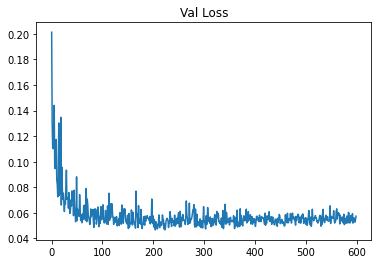

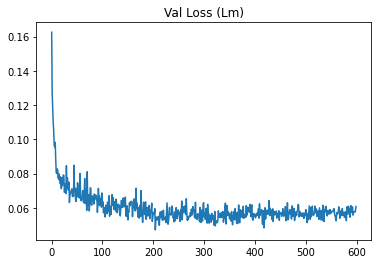

In [9]:
val_best_loss = 10000000
val_best_loss_lm = 10000000
val_loss_list = []
val_loss_lm_list = []

if not os.path.exists(exp_path):
    os.mkdir(exp_path)
print("Training ", end='')
for epoch_idx in range(n_epochs):
    print('=', end='')
    # print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    train(encoder,decoder,Q,opt,train_data_loader)    
    val_losses = validate(encoder,decoder,Q,val_data_loader) 
    val_losses_lm = validate_with_lm(encoder,is_wandb=False,is_verbose = False) 

    val_loss_list.append(val_losses)
    val_loss_lm_list.append(val_losses_lm)
    # break
    if (val_losses < val_best_loss): 
        val_best_loss = val_losses
        # print("Saving Best Model =======================================>")
        torch.save(encoder, f'{exp_path}/encoder.pth.tar')
        torch.save(decoder, f'{exp_path}/decoder.pth.tar')
        torch.save(Q, f'{exp_path}/Q.pth.tar')
    if (val_losses_lm < val_best_loss_lm): 
        val_best_loss_lm = val_losses_lm
        # print("Saving Best Model =======================================>")
        torch.save(encoder, f'{exp_path}/encoder_lm.pth.tar')
        torch.save(decoder, f'{exp_path}/decoder_lm.pth.tar')
        torch.save(Q, f'{exp_path}/Q_lm.pth.tar')
    
plt.figure()
plt.plot(val_loss_list)
plt.title("Val Loss")

plt.figure()
plt.plot(val_loss_lm_list)
plt.title("Val Loss (Lm)")



# Inference for predicting conterfactual outcomes

In [10]:
#Load encoder
# enc_path = f'{exp_path}/encoder.pth.tar'
enc_path = f'{exp_path}/encoder_lm.pth.tar'
encoder = torch.load(enc_path).to(DEVICE)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

166272


In [11]:
x_treat,t_treat,m_treat,y_treat,y_mask_treat,batch_ind_treat,treatment_effect = read_data_inference(data_path, fold = 'test',device = DEVICE,group = 'Treated')
print(x_treat.shape,t_treat.shape,m_treat.shape,y_treat.shape,y_mask_treat.shape,batch_ind_treat.shape,treatment_effect.shape)

x_control,t_control,m_control,y_control,y_mask_control,batch_ind_control = read_data_inference(data_path, fold = 'test',device = DEVICE,group = 'Control')
print(x_control.shape,t_control.shape,m_control.shape,y_control.shape,y_mask_control.shape,batch_ind_control.shape)

torch.Size([200, 25, 3]) torch.Size([200, 25, 3]) torch.Size([200, 25, 3]) torch.Size([200, 5]) torch.Size([1200]) torch.Size([200]) torch.Size([200, 5, 1])
torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 25, 3]) torch.Size([1000, 5]) torch.Size([1200]) torch.Size([1000])


torch.Size([200, 1600]) torch.Size([1000, 1600])
Features Shape :torch.Size([1200, 1600])
Flattened Features Shape :torch.Size([1200, 1600])
Fitting T-SNE on features ======>


/home/jupyter-jathurshan/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-jathurshan/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


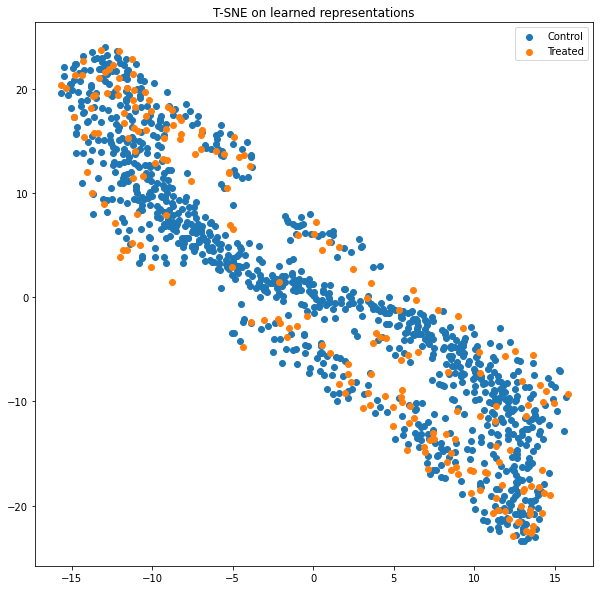

In [12]:
c_treat = get_representation(encoder,x_treat,m_treat).detach().to(DEVICE).requires_grad_(False)
c_control = get_representation(encoder,x_control,m_control).detach().to(DEVICE).requires_grad_(False)

print(c_treat.shape,c_control.shape)

tsne_feat = get_tsne(c_treat,c_control)

### For one Treated Sample

Tensor Shapes, B: torch.Size([1000, 1]), c_target: torch.Size([1600]), c_non_target: torch.Size([1000, 1600])


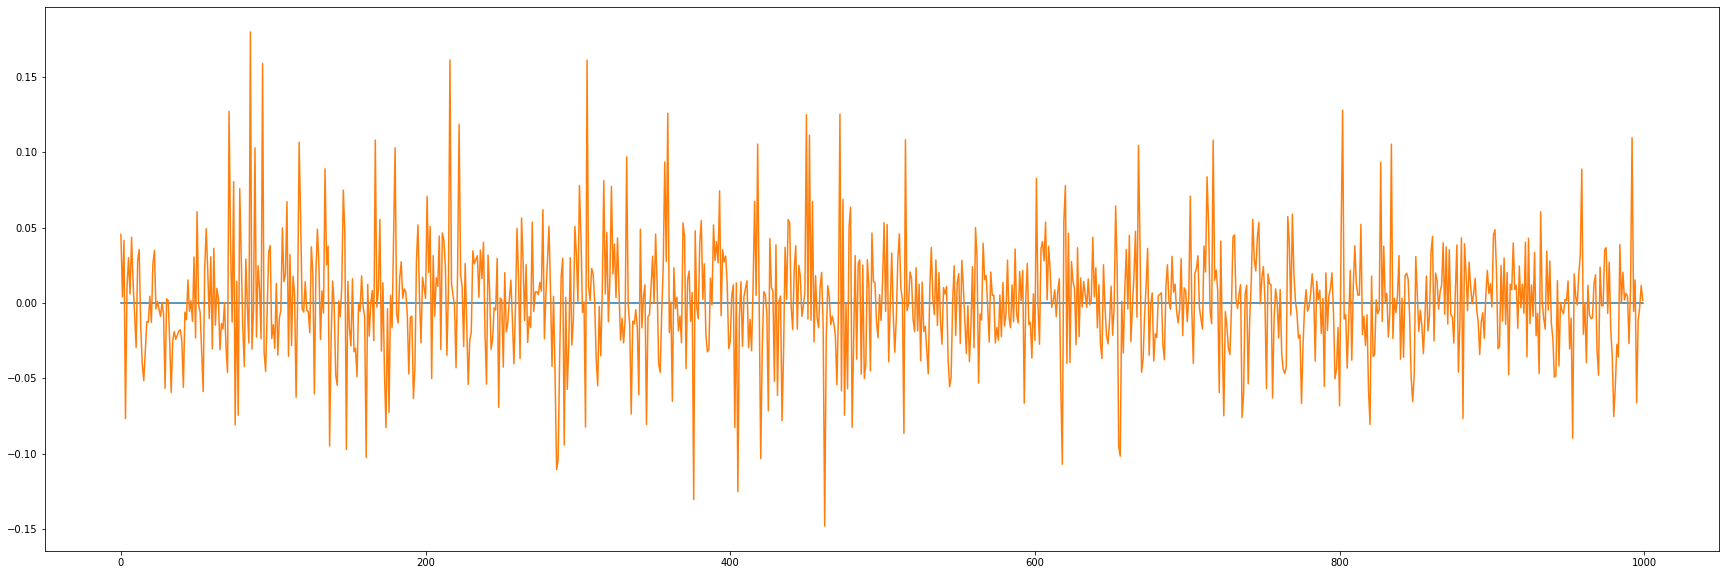

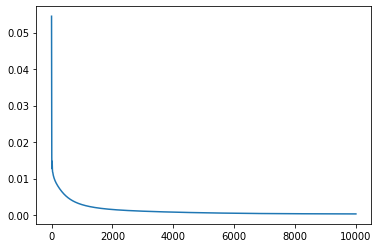

torch.Size([1000, 1]) torch.Size([1000, 5])
torch.Size([200, 5, 1]) torch.Size([5]) torch.Size([1, 5])


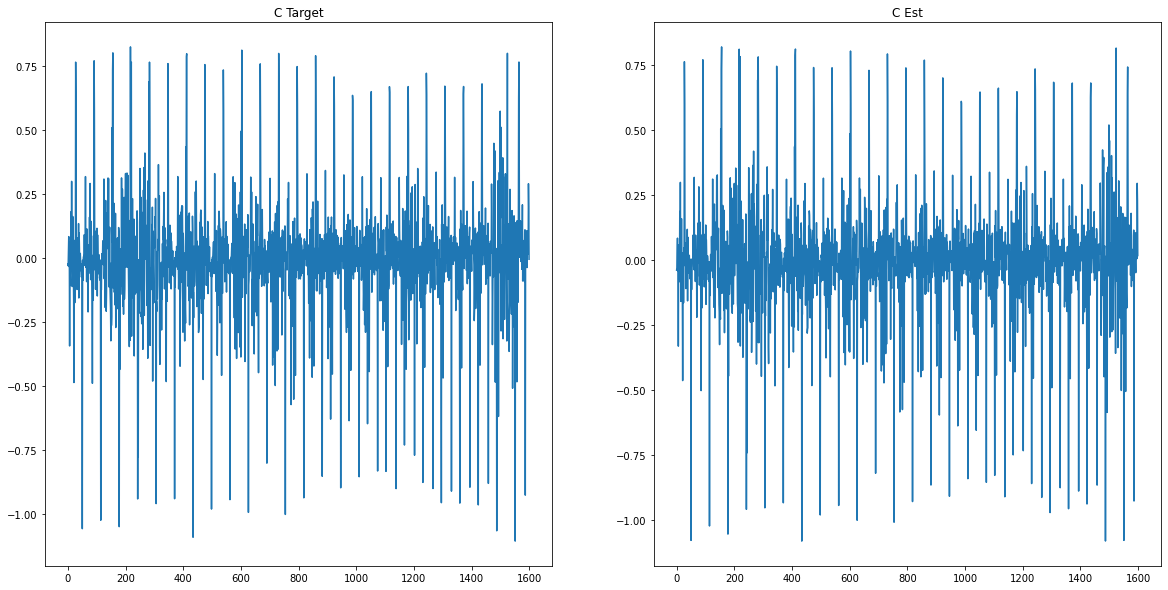

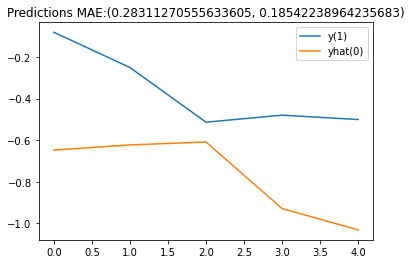

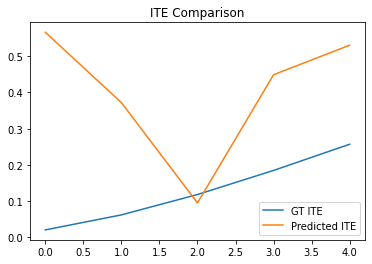

In [13]:
i = 12#14:0#12:2
B_treat = learn_B_for_one_sample(c_treat[i],c_control,num_iterations =10000,is_plot = True)

y_hat = estimate_y_one_sample(B_treat,y_control)

print(treatment_effect.shape,y_treat[i].shape,y_hat.shape)

plt.figure()
plt.plot(y_treat[i].squeeze().detach().cpu().numpy(),label = "y(1)")
plt.plot(y_hat.squeeze().detach().cpu().numpy(),label = "yhat(0)")
plt.title(f"Predictions MAE:{calculate_mae(y_hat,y_treat[i].unsqueeze(0),treatment_effect[i].squeeze().unsqueeze(0))}")
plt.legend(loc='best')

plt.figure()
plt.plot(treatment_effect[i].squeeze().detach().cpu().numpy(),label = "GT ITE" )
plt.plot((y_treat[i].unsqueeze(0) - y_hat).squeeze().detach().cpu().numpy(),label = "Predicted ITE" )
plt.title("ITE Comparison")
plt.legend(loc='best')

### For Multiple Treated Samples

Tensor Shapes, B: torch.Size([200, 1000]), c_target: torch.Size([200, 1600]), c_non_target: torch.Size([1000, 1600])


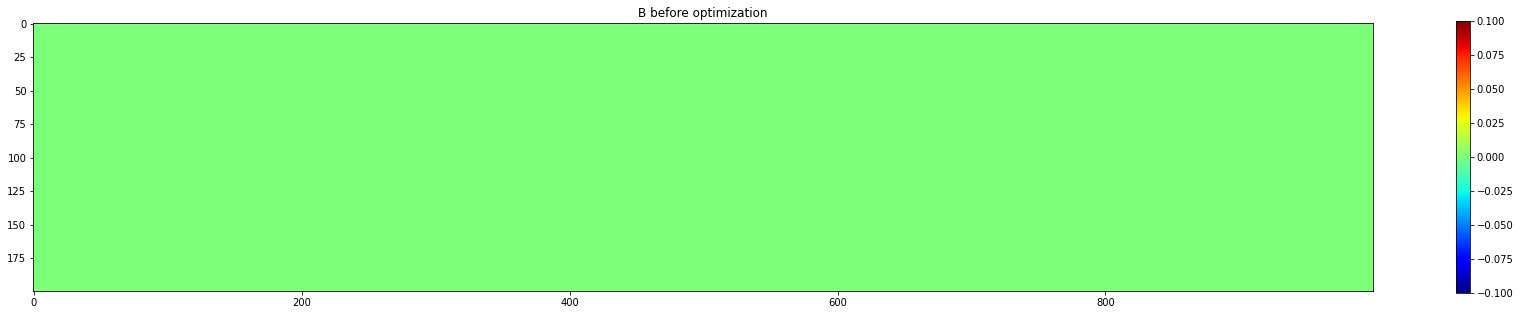

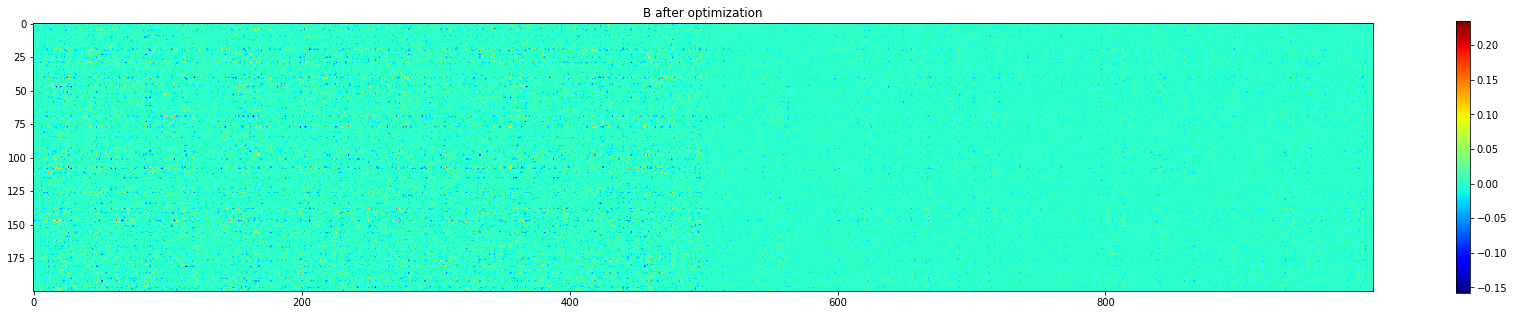

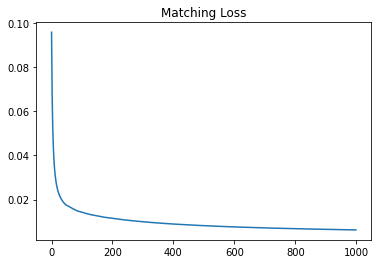

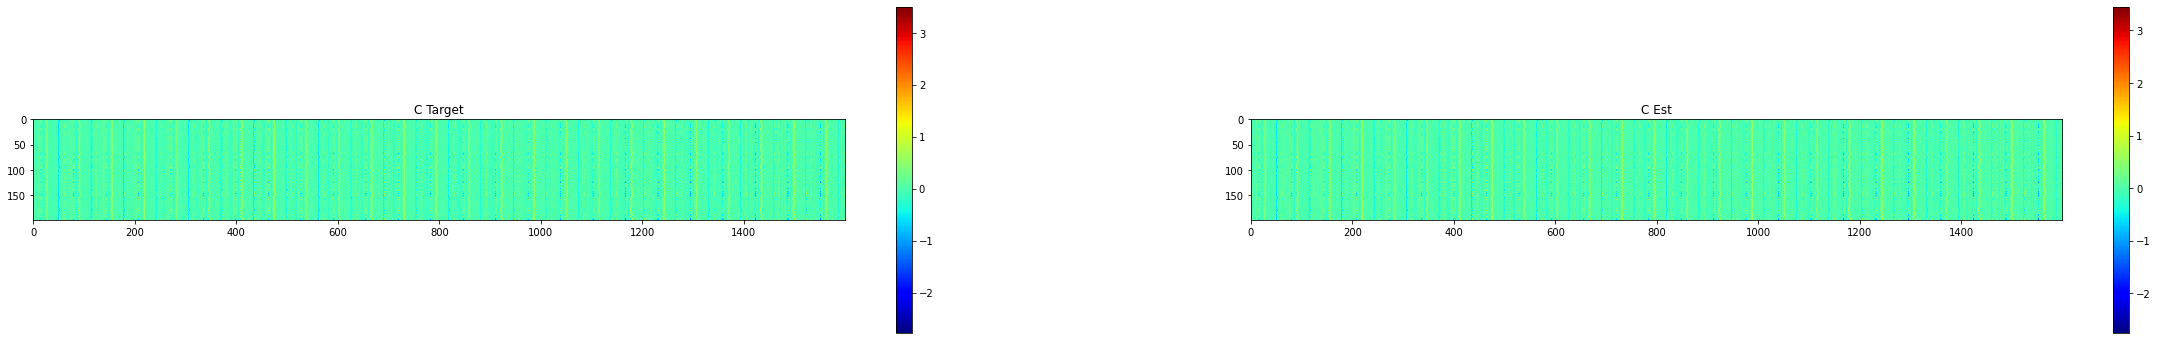

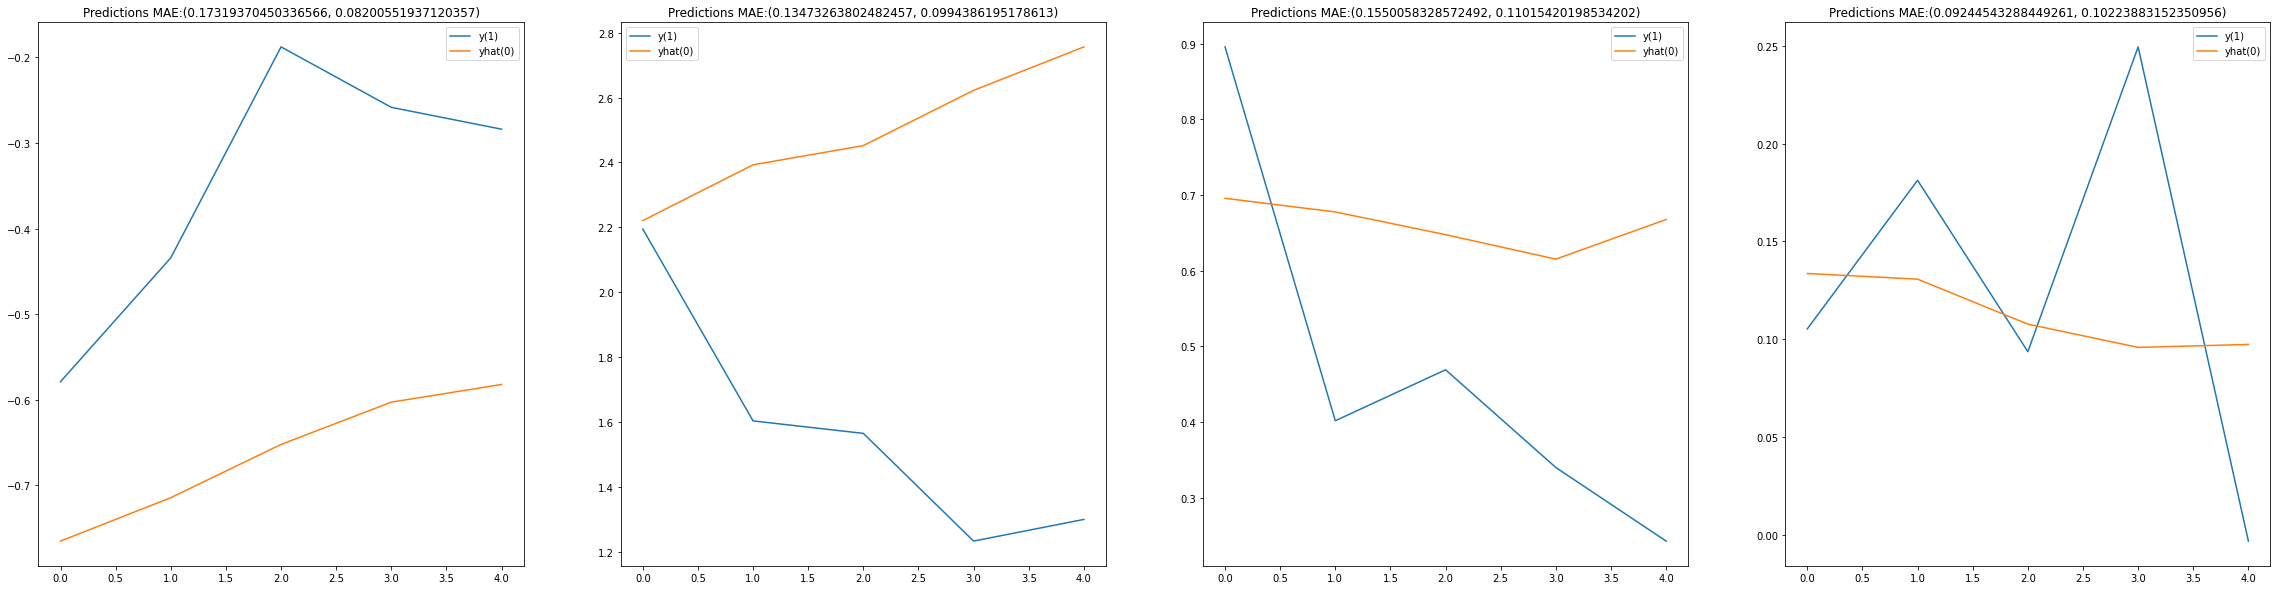

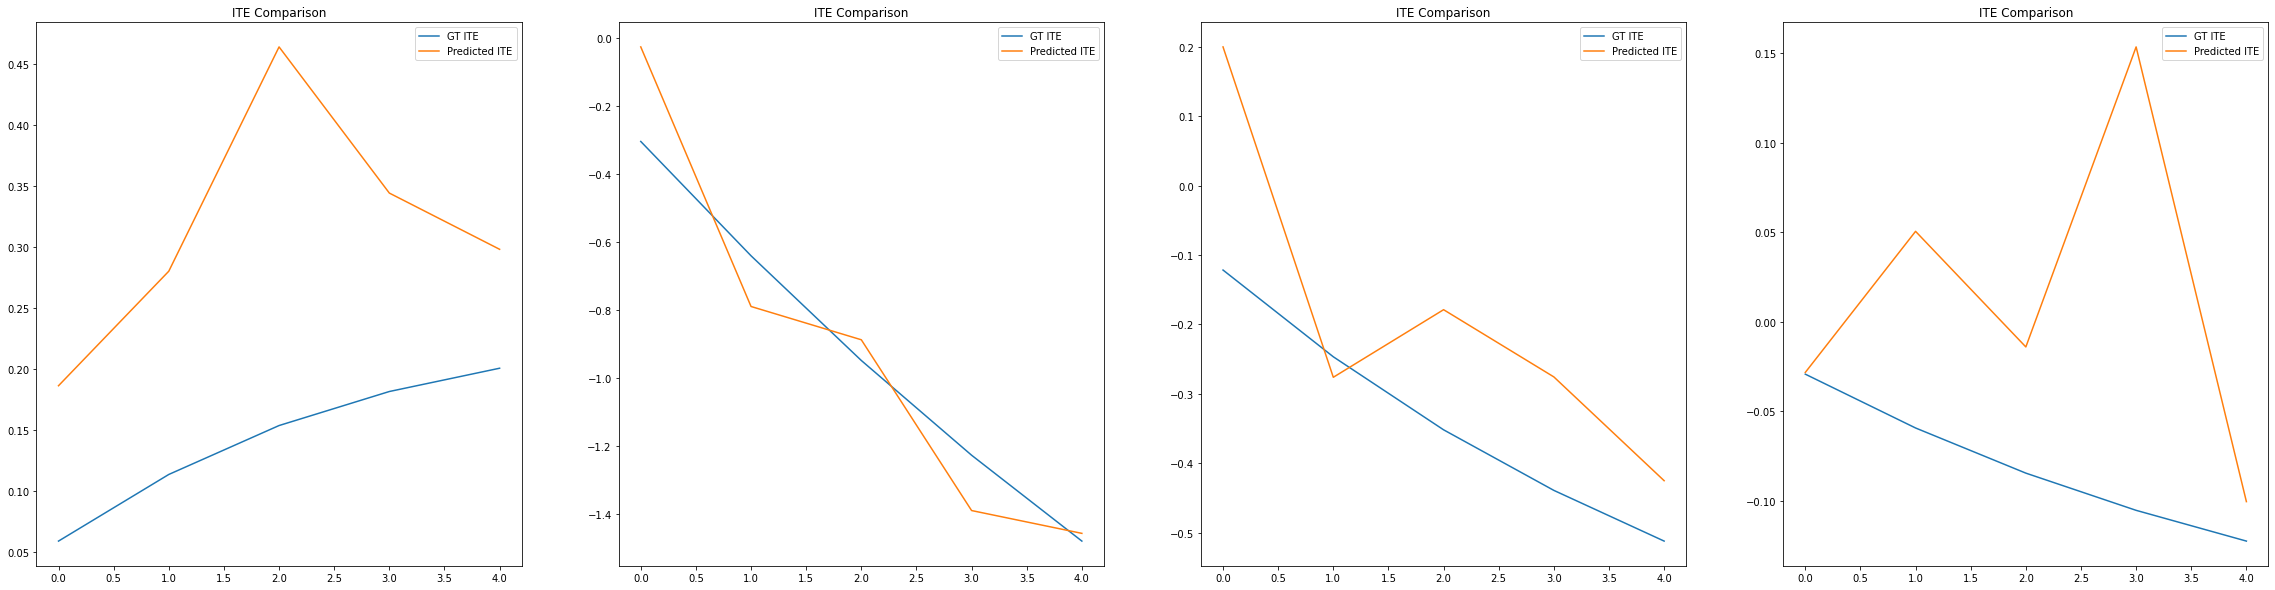

Experiment Results : MAE: 0.1576529768466214 (0.009840201197834787)


In [14]:
B_treat = learn_B(c_treat,c_control,num_iterations =1000,is_plot = True)

y_hat_main = estimate_y(B_treat,y_control)

random_list = [3,5,1,6]
fig, axs = plt.subplots(1, 4, figsize = (40,10))
c = 0
for i in random_list:
    axs[c].plot(y_treat[i].squeeze().detach().cpu().numpy(),label = "y(1)")
    axs[c].plot(y_hat_main[i].squeeze().detach().cpu().numpy(),label = "yhat(0)")
    axs[c].set_title(f"Predictions MAE:{calculate_mae(y_hat_main[i],y_treat[i].unsqueeze(0),treatment_effect[i].squeeze().unsqueeze(0))}")
    axs[c].legend(loc='best')
    c+=1
plt.show()

fig, axs = plt.subplots(1, 4, figsize = (40,10))
c = 0
for i in random_list:
    axs[c].plot(treatment_effect[i].squeeze().detach().cpu().numpy(),label = "GT ITE" )
    axs[c].plot((y_treat[i].unsqueeze(0) - y_hat_main[i].unsqueeze(0)).squeeze().detach().cpu().numpy(),label = "Predicted ITE")
    axs[c].set_title("ITE Comparison")
    axs[c].legend(loc='best')
    c+=1
plt.show()
mae,mae_sd = calculate_mae(y_hat_main,y_treat,treatment_effect.squeeze())
print(f"Experiment Results : MAE: {mae} ({mae_sd})")


In [15]:
#Experiment Results (Transformer based method) : MAE: 0.09584333731090948 (0.005139202060265389)

In [16]:
#p=0.1
#Experiment Results (Transformer based method) : MAE: 0.09807996657274436 (0.005298893495160766)
#Experiment Results (Transformer based method: best lm) : MAE: 0.09828328460561522 (0.005276029255709818)

#Experiment Results (LSTM based method) : MAE: 0.12109243731024606 (0.008080741730420497)
#Experiment Results (LSTM based method_best matching loss val) :MAE: 0.11880329205036393 (0.007911388072890498)

#Experiment Results (1D CNN based method_best): MAE: 0.09539035537372183 (0.005146664556748842)
#Experiment Results (1D CNN based method_best matching loss val): MAE: 0.09539035537372183 (0.005146664556748842)

#Experiment Results (NN based method_best): MAE: 0.12224117186162789 (0.006938084342968118)
#Experiment Results (NN based method_best matching loss val): MAE: 0.15934595244391025 (0.01012918239977666)

In [17]:
#p=0.25
#Experiment Results (Transformer based method: best lm) : MAE: 0.09054041285924366 (0.00479318896978323)

# Experiment Results (LSTM based method_best matching loss val): MAE: 0.10138582096047402 (0.005872187273766361)

#Experiment Results (1D CNN based method_best matching loss val): MAE: 0.09088118000515887 (0.004914969607775508)

#Experiment Results (NN based method_best matching loss val): MAE: 0.11221592089804061 (0.006008722771584831)



In [18]:
#p=0.5
#Experiment Results (Transformer based method: best lm) : MAE: 0.0884316525283125 (0.004702200994225696)

# Experiment Results (LSTM based method_best matching loss val): MAE: 0.09726002678924289 (0.0062122419295944425)

#Experiment Results (1D CNN based method_best matching loss val): MAE: 0.0888792247659261 (0.004807005318845887)

#Experiment Results (NN based method_best matching loss val): MAE: 0.09266086980081202 (0.005009746226938197)



In [19]:
#m=0.3
#Experiment Results (Transformer based method: best lm) : MAE: 0.14304397311497627 (0.008438082747382353)

# Experiment Results (LSTM based method_best matching loss val): MAE: 0.13578832479707728 (0.0074805843200974505)


#Experiment Results (1D CNN based method_best matching loss val): MAE: 0.13919939922076977 (0.008248656314295744)


#m=0.5
#Experiment Results (Transformer based method: best lm) : MAE: 0.15695605576947114 (0.009482951684095811)

# Experiment Results (LSTM based method_best matching loss val): MAE: 0.22302700311579549 (0.01423200419424768)


#Experiment Results (1D CNN based method_best matching loss val): MAE: 0.1734314232596672 (0.010136664861223645


#m=0.7
#Experiment Results (Transformer based method: best lm) : MAE: 0.1576529768466214 (0.009840201197834787)

# Experiment Results (LSTM based method_best matching loss val): MAE: 0.24047572229257458 (0.014925550243633465)


#Experiment Results (1D CNN based method_best matching loss val): MAE: 0.26865624884452916 (0.01851118352622534)



